In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text



from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib

In [2]:
corrections = {
    "MGI" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1128691_20170206_S' : '1128691_20171206_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '1723809_20180227_S' : '1085876_20180227_S',
        '649354_20170206_S' : '639354_20171206_S',
        '652927_20180226_S' : '715927_20180226_S',
        '658355_20180301_S' : '658355_20180327_S',
        '777851_20170918_S' : '778851_20170918_S',
        '788707_20181126_S' : '788707_20181129_S'
    },
    "minion" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '698917_20190119_S' : '698917_20180119_S'
        }
}

pathogens = {
    "Streptococcus",
    "Staphylococcus",
    "Haemophilus",
    "Mycobacterium",
    "Pseudomonas",
    "Klebsiella",
    "Moraxella",
    "Bordetella",
    "Legionella",
    "Corynebacterium",
    "Chlamydia",
    "Mycoplasma",
    "Neisseria",
    "Burkholderia",
    "Acinetobacter",
    "Francisella",
    "Escherichia",
    "Pasteurella",
    "Nocardia",
    "Actinomyces"
}

def read_taxonomy(tax_file, firstchar, sequence_type):
    """
    Read the taxonomy file and return a data frame
    """

    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None

    df = pd.read_csv(tax_file, sep='\t', compression='gzip')
    df = df[df['taxonomy'].str.contains('k__Bacteria')]
    df = df[~df['taxonomy'].str.endswith(f'{firstchar}__')]
    df = df.set_index('taxonomy')
    df = df.rename(columns=corrections[sequence_type])
    df.index = df.index.str.replace(f'{firstchar}__', '').str.replace('Candidatus ', '')
    df.index = df.index.str.split(';').str[-1]

    df = df.sort_index(axis=1)
    return df

def read_metadata(sequence_type):
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None

    metadata = pd.read_csv(os.path.join(datadir, "Metadata/Metadata.tsv"), encoding='windows-1252', sep="\t", index_col=0)
    metadata = metadata[~metadata[sequence_type].isna()]

    metadata = metadata.rename(columns={'Pseudomonas': 'Pseudomonas Culture'})

    for ix in metadata.index:
        s = metadata.loc[ix, sequence_type]
        if s in corrections[sequence_type]:
            metadata.loc[ix, sequence_type] = corrections[sequence_type][s]
    return metadata

def sorted_presence_absence(df1, df2, minrowsum=0, asc_sort=False):
    """
    Join the two tables and return the sorted version
    """
    # filter so we only include samples sequenced on both MGI and MinION
    common_columns = df1.columns.intersection(df2.columns)
    df1_both = df1[common_columns]
    df2_both = df2[common_columns]

    # create a presence/absence matrix
    df1_presence = (df1_both > 0).astype(int)
    df2_presence = (df2_both > 0).astype(int)*2

    # here we filter on the minimum number of columns each taxa is in if requested
    if minrowsum > 0:
        df1_presence = df1_presence.loc[df1_presence[df1_presence.sum(axis=1) > minrowsum].index]
        df2_presence = df2_presence.loc[df2_presence[df2_presence.sum(axis=1) > (2 * minrowsum)].index]

    # combine the two matrices and sort them
    both = df1_presence.add(df2_presence, fill_value=0)
    sboth = both.loc[both.sum(axis=1).sort_values(ascending=asc_sort).index]
    sboth = sboth.sort_index(axis=1) # sort by column names

    return sboth

In [3]:
tax='genus'
# read the data

mgi_df = read_taxonomy(os.path.join(datadir, f"MGI/Taxonomy/MGI_reads_{tax}.normalised.tsv.gz"), tax[0], "mgi")
min_df = read_taxonomy(os.path.join(datadir, f"MinION/Taxonomy/minion_reads_{tax}.normalised.tsv.gz"), tax[0], "minion")
mgi_metadata = read_metadata("MGI")
minion_metadata = read_metadata("minion")
# sequence_type = "MGI"
sequence_type = "minion"

if sequence_type == "MGI":
    df = mgi_df.T
    metadata = mgi_metadata
else:
    df = min_df.T
    metadata = minion_metadata

df = df.rename_axis('NAME')
metadata = metadata[~metadata[sequence_type].isna()]

In [4]:
allintcols = ['IP vs OP', 'Hospital', 'Room', 'Age', 'Age groups', 'Paediatric vs Adult', 'Gender',
              'H2_Corrected', 'CH4_Corrected', 'CH4/H2 ratio_corrected', 'NTM', 'Pseudomonas Culture',
              'IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FVC', 'FEV1', 'Best FEV1', 'FEV1/best FEV1',
              'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Cystic Fibrosis related diabetes (CFRD)',
              'Pancreatic insufficiency (PI)']
metadata[allintcols].dtypes

IP vs OP                                    object
Hospital                                    object
Room                                        object
Age                                          int64
Age groups                                   int64
Paediatric vs Adult                         object
Gender                                      object
H2_Corrected                               float64
CH4_Corrected                              float64
CH4/H2 ratio_corrected                     float64
NTM                                        float64
Pseudomonas Culture                        float64
IgE                                        float64
Spec IgE                                   float64
Spec IgG                                    object
Precipitins                                float64
FVC                                        float64
FEV1                                       float64
Best FEV1                                    int64
FEV1/best FEV1                 

In [5]:
def random_forest_regression(X, y):
  """
  Run a regressor for continuous data and return the mean squared error and the feature importances
  """

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and train a RandomForestRegressor model
  model = RandomForestRegressor(random_state=42, n_estimators = 100) # You can adjust hyperparameters
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)

  # Feature importance
  feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
  return mse, feature_importances_sorted

def random_forest_classifier(X, y):
  """
  Run a classifier for categorical data and return the mean squared error and the feature importances
  """

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and train a RandomForestRegressor model
  model = RandomForestClassifier(random_state=42, n_estimators = 100) # You can adjust hyperparameters
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)

  # Feature importance
  feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
  return mse, feature_importances_sorted



def plot_feature_importance(ax, feature_importances_sorted, title):

  # Create dotted lines and circles for each feature
  for feature in feature_importances_sorted.index[::-1]:
      importance = feature_importances_sorted.loc[feature, 'importance']
      ax.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
      ax.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

  ax.set_xlabel("Importance")
  ax.set_ylabel(f"Bacteria")
  ax.set_title(title)



Mean Squared Error for all bacteria: 0.014108833388999683


Regressing


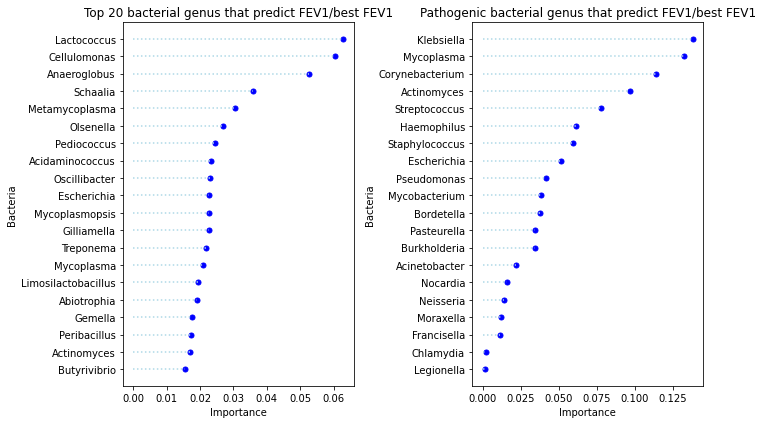

In [6]:
# Merge the dataframes
intcol = 'FEV1/best FEV1' # interesting column!
merged_df = df.join(metadata[[intcol]].dropna(), how='inner')

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if metadata[intcol].dtype == 'object':
  mse, feature_importances_sorted = random_forest_classifier(X, y)
  met = 'classification'
else:
  mse, feature_importances_sorted = random_forest_regression(X, y)
  met = 'regression'

print(f"Mean Squared Error for all bacteria: {mse}")

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2)

plot_feature_importance(axes[0], feature_importances_sorted[:20], f"Top 20 bacterial {tax} that predict {intcol}")



# this data set models just the pathogens
X = merged_df[list(pathogens)] # Features (bacteria counts)
y = merged_df[intcol] # Target variable

if metadata[intcol].dtype == 'object':
  print("Classifying", file=sys.stderr)
  mse, feature_importances_sorted = random_forest_classifier(X, y)
else:
  print("Regressing", file=sys.stderr)
  mse, feature_importances_sorted = random_forest_regression(X, y)


plot_feature_importance(axes[1], feature_importances_sorted, f"Pathogenic bacterial {tax} that predict {intcol}")

plt.tight_layout()
plt.show()

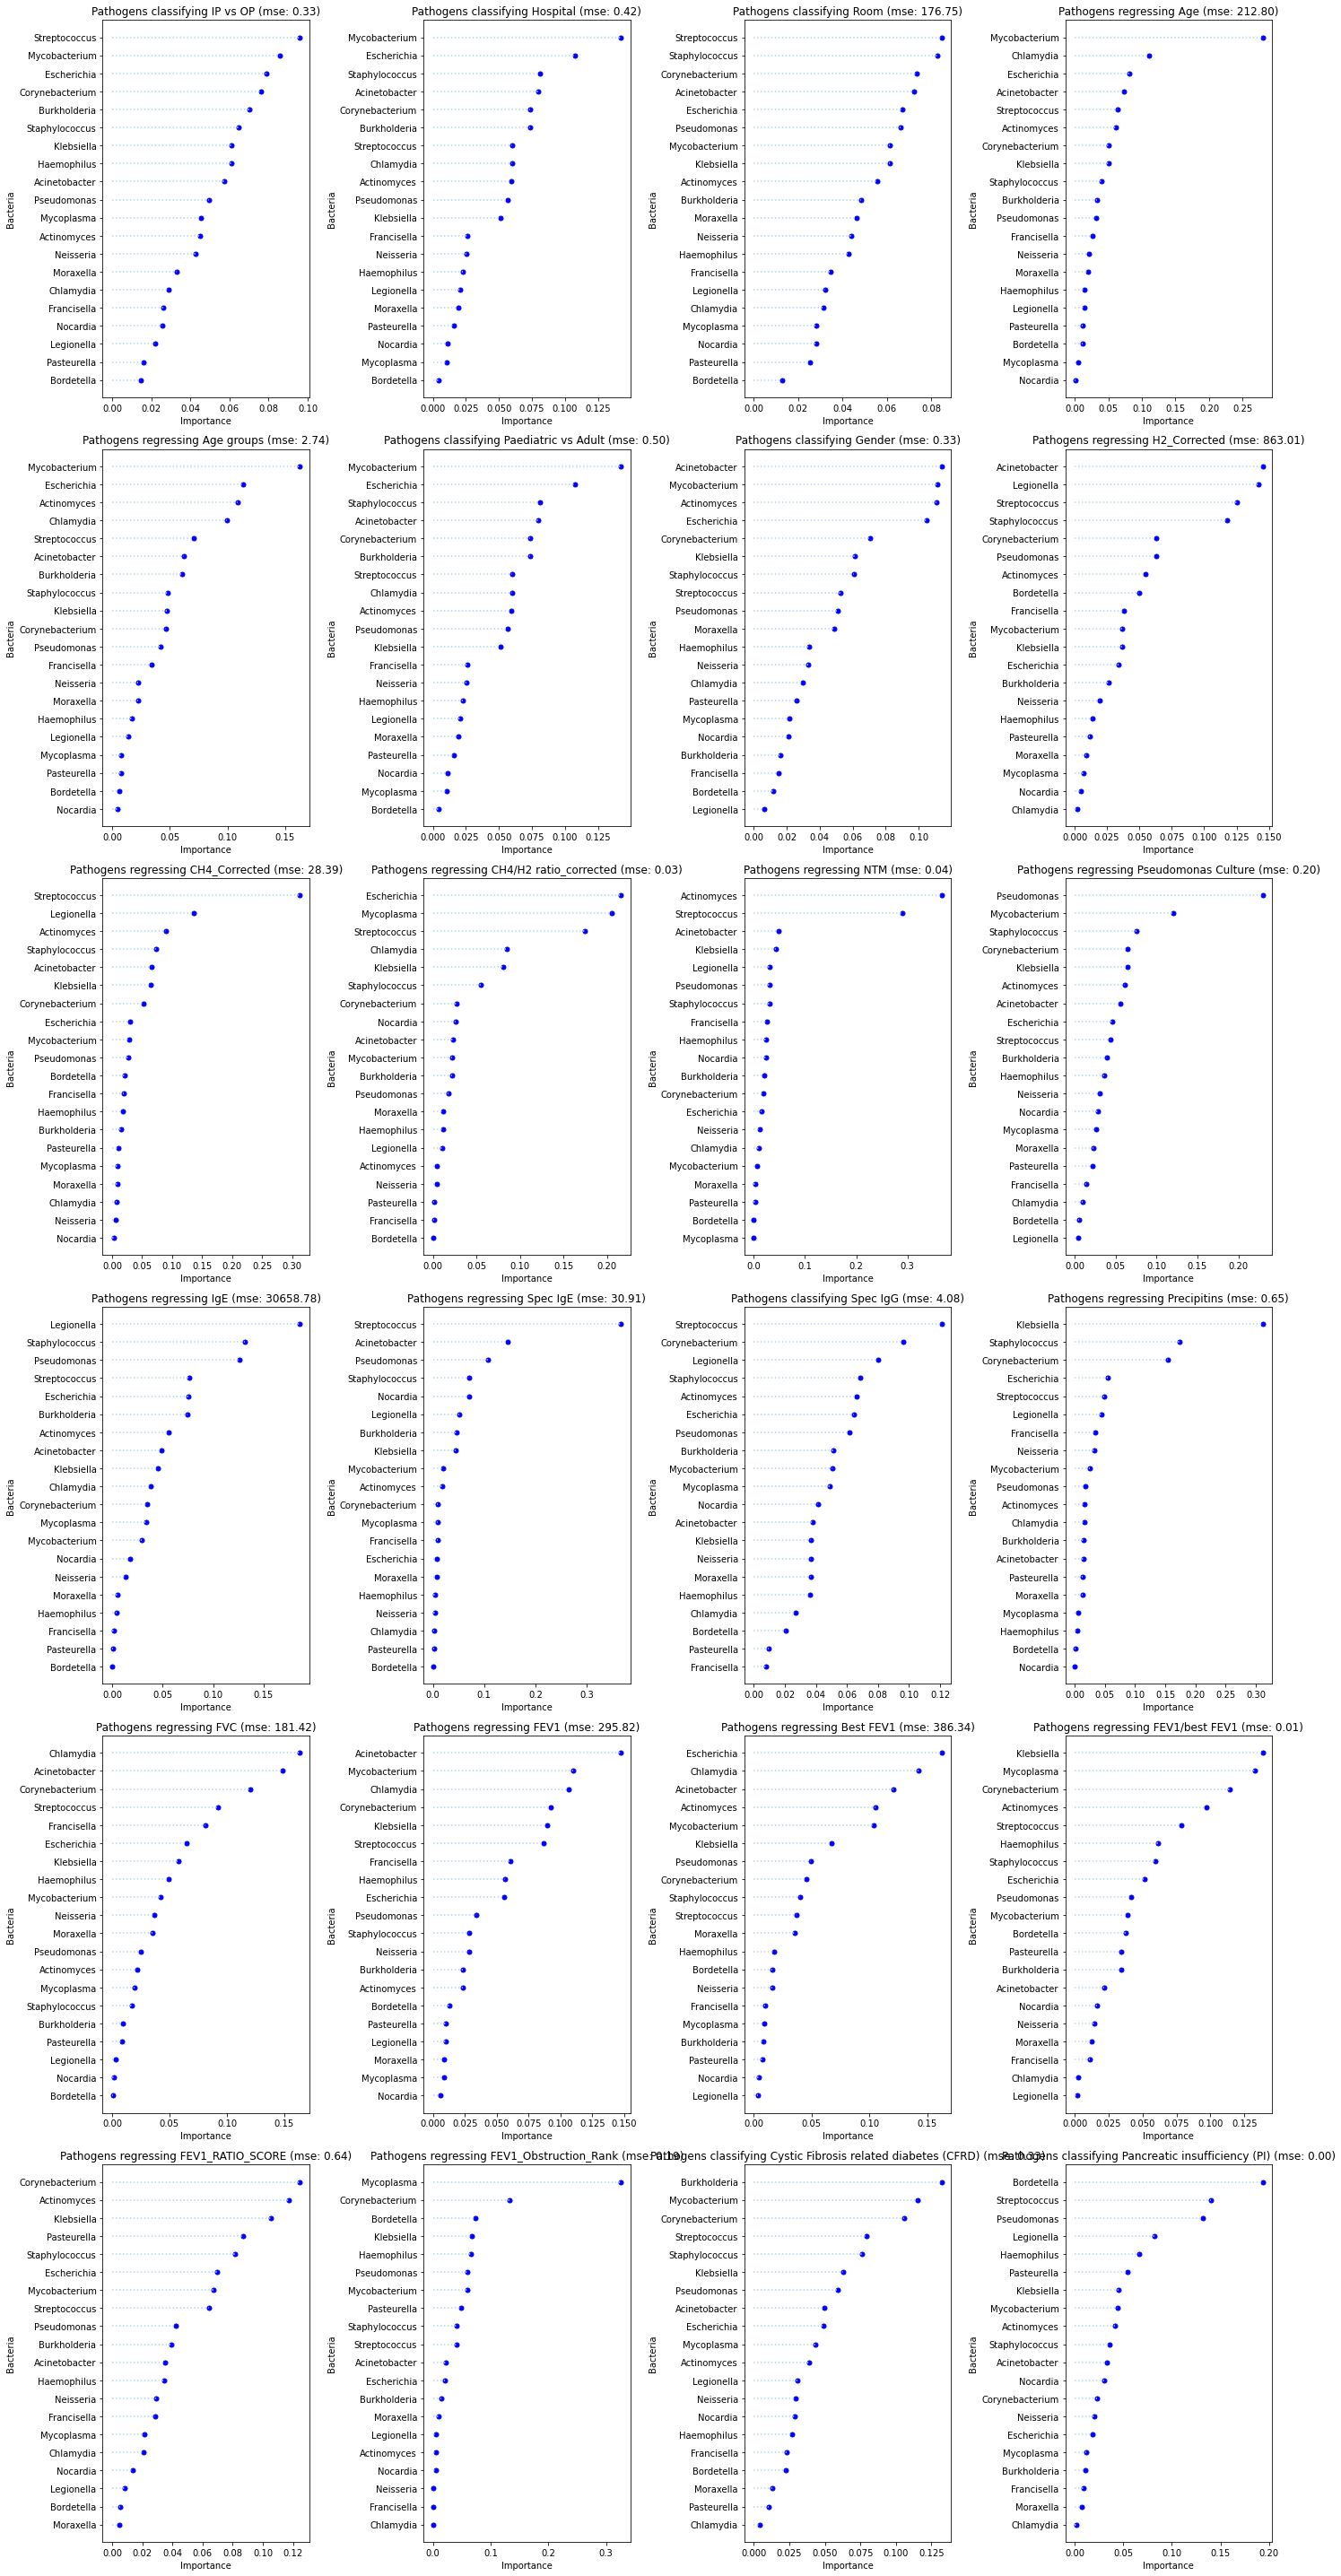

In [7]:
allintcols = ['IP vs OP', 'Hospital', 'Room', 'Age', 'Age groups', 'Paediatric vs Adult', 'Gender',
              'H2_Corrected', 'CH4_Corrected', 'CH4/H2 ratio_corrected', 'NTM', 'Pseudomonas Culture',
              'IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FVC', 'FEV1', 'Best FEV1', 'FEV1/best FEV1',
              'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Cystic Fibrosis related diabetes (CFRD)',
              'Pancreatic insufficiency (PI)']

fig, axes = plt.subplots(figsize=(20,40), nrows=6, ncols=4)
label_encoder = LabelEncoder()

for i, intcol in enumerate(allintcols):
  ax = axes[i//4, i%4]

  if metadata[intcol].dtype == 'object':
    m = metadata[[intcol]].copy()
    m["enc"] = label_encoder.fit_transform(m[intcol])
    merged_df = df.join(m[["enc"]].dropna(), how='inner')
    merged_df = merged_df.rename(columns={"enc": intcol})
  else:
    merged_df = df.join(metadata[[intcol]].dropna(), how='inner')

  # this data set models all bacteria
  # X = merged_df.drop(intcol, axis=1)
  X = merged_df[list(pathogens)]
  y = merged_df[intcol]

  if metadata[intcol].dtype == 'object':
    mse, feature_importances_sorted = random_forest_classifier(X, y)
    met = 'classifying'
  else:
    mse, feature_importances_sorted = random_forest_regression(X, y)
    met = 'regressing'


  plot_feature_importance(ax, feature_importances_sorted[:20], f"Pathogens {met} {intcol} (mse: {mse:.2f})")


plt.tight_layout()
plt.show()
